# Minería de reglas de asociación espacial sobre Minecraft

## El Proyecto
Este proyecto tiene como objetivo la aplicación de algoritmos de Inteligencia Artificial. La idea inicial consistió en buscar una solución a un problema particular que se puede explicar de la siguiente manera:

Dentro de la industria de creación de videojuegos existe un area grande e importante que consiste en la generación procedural.
Se le llama generación procedural de contenido, o **PCG** (*Procedural Content Generation*) por sus siglas en ingles, a la creación algorítmica de contenido para videojuegos con entradas del usuario limitadas o indirectas. [*Procedural Content
Generation in Games_ Noor Shaker,Julian Togelius,Mark J. Nelson*].  

Dentro de este area existen varios algoritmos que permiten la generación de contenido a partir de el establecimiento de parámetros de entrada que permiten al Diseñador orientar el funcionamiento del algoritmo. Teniendo en cuenta esta característica surge la pregunta: 
- ¿Sería posible mediante un algoritmo de inteligencia artificial y un entorno no generado artificialmente, poder *inferir* parámetros para que el algoritmo genere entornos similares?  

O de otra manera:
- ¿Puedo ***inferir las relaciones*** que existen entre los objetos de un entorno dado y, a partir de ellos, establecer parámetros para un algoritmo de generación procedural?

Debido a la extension que conllevaría realizar un proyecto para contestar estas preguntas, se decidió que el enfoque del proyecto estará en la búsqueda y comparación de algoritmos de inteligencia artificial que permitan la descripción, aprendizaje o inferencia de las relaciones que existen entre objetos en un espacio físico o virtual.

Con la exploración bibliográfica se puede entender que existe un area de investigación dentro de la ciencia en minería de datos que enfocada en como realizar las tareas de minería de datos sobre bases de datos espaciales o geográficas. La **Minería de Datos Espaciales** o **SDM** es un proceso de descubrimiento y extracción de conocimiento generalizado sobre gran cantidad de datos espaciales. [Spatial Data Mining_ Theory and Application_Deren L., Shuliang W., Deyi L]

El proyecto entonces consistirá en la aplicación de algunas técnicas y algoritmos utilizados en el area de *SDM* para realizar la inferencia de relaciones entre objetos espaciales en un entorno. Concretamente, los aplicaremos sobre un conjunto de datos extraídos del Videojuego *Minecraft*.

*Minecraft* es un videojuego 3D que utiliza un complejo procedimiento de generación procedural para la creación de terrenos de juego utilizando bloques. Se toma este escenario para la realización del proyecto debido a que los datos correspondientes a un terreno generado en el videojuego son de fácil acceso y la extracción de es sencilla, además, la disposición de los objetos dentro del juego son bloques con coordenadas rectangulares. Se puede obtener mas información sobre el procedimiento de generación procedural en está pagina web: [The World Generation of Minecraft](https://www.alanzucconi.com/2022/06/05/minecraft-world-generation/).

In [1]:
#Imports

import apriori
import preprocess
import ploting

## Obtención de los datos del Videojuego
Para extraer la información sobre los bloques de Minecraft utilizare la información brindada por esta pagina web:[Minecraft Region file format](https://minecraft.fandom.com/wiki/Region_file_format). 

En la capeta de instalación del videojuego encontramos una carpeta donde se guarda la información cada mundo generado llamada ``saves``. Dentro de la carpeta del mundo encontramos la sub-carpeta ``region``. Esta carpeta contiene varios archivos con formato *.mca*. Los archivos *.mca* tienen un patron de nombramiento que depende de las regiones del juego que se han generado, por cada region generada existe un archivo que contiene la información de 32x32 *chunks*. Siendo *x* y *z* las coordenadas de una región los archivos se nombran como *r.x.z.mca*.
Cada *Chunk* guarda el terreno, las entidades en un area de 16x16x255 donde el ancho y largo es 16 y la altura es 255. Además guarda iluminación precomputalizada, mapas de altura y otra información que no es de nuestro interés.

Para "parsear" estos archivos y extraer la información de los bloques en un archivo de región utilizaremos la biblioteca **anvil**.
Una vez parseado guardaremos el chunk en formato .csv y utilizaremos la biblioteca **pandas** para trabajar y manipular los datos.

In [2]:
#Path del CSV
csvPath = "..\\..\\Data\\chunks.csv"

In [3]:
#Extracción de los bloques
import chunkParser
mcaPath = "..\\..\\Data\\region_new\\r.0.0.mca"
with open(csvPath,'w') as csvFile:
    chunkParser.mcaCSV(csvFile,mcaPath);

In [4]:
#Lectura del CSV
import pandas as pd
df = pd.read_csv(csvPath,delimiter=";",lineterminator="\n")
print(df)

         Bid   X    Y   Z      Tag  ChunkX  ChunkZ\r
0          0   0    0   0  bedrock       0         0
1          1   0    1   0  bedrock       0         0
2          2   0    2   0  bedrock       0         0
3          3   0    3   0    stone       0         0
4          4   0    4   0    stone       0         0
...      ...  ..  ...  ..      ...     ...       ...
9811120  278  14  250  14      air       1         8
9811121  279  14  251  14      air       1         8
9811122  280  14  252  14      air       1         8
9811123  281  14  253  14      air       1         8
9811124  282  14  254  14      air       1         8

[9811125 rows x 7 columns]


## Análisis de Datos de entrada

El terreno que utilizare fue generado por la version 1.10.2 del videojuego. Versiones más resientes existen pero no son soportadas por el visualizador. Utilizando el [visualizador](http://pessimistress.github.io/minecraft/). El terreno del cual he extraído los bloques se ve de la siguiente manera:
![top_view](../Images/)
Utilizando otro vizualizador:
![3d_view]()

AttributeError: 'AxesSubplot' object has no attribute 'show'

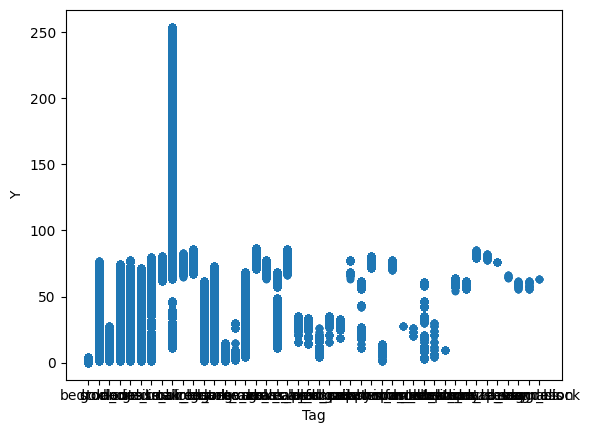

In [5]:
import matplotlib.pyplot as plt 
my_plot = df.plot("Tag", "Y", kind="scatter")
my_plot.show()

In [ ]:

#Data analysis
    #Ploting and metrics
#Preprocess
preprocess.basic()
preprocess.cloudModel()
preprocess.comceptLattice()

#Run Apriori Algorithm

#Generate metrics and plots from Result
    #Ploting and Metrics


# Bibliografía y Papers relacionados #

## Association Rules mining ##

+ [Métricas para reglas de association](https://towardsdatascience.com/association-rules-2-aa9a77241654)
+ [Priori en R](https://www.geeksforgeeks.org/association-rule-mining-in-r-programming/#:~:text=Association%20Rule%20Mining%20in%20R%20Language%20is%20an%20Unsupervised%20Non,in%20a%20transaction%20or%20relation.)
+ [Lista de algoritmos para minería de reglas de asociación](https://personal.ntu.edu.sg/assourav/Unpublished/UP-ARMSurvey.pdf)

## Spacial Association Rules mining ##

+ [Enhancing spatial association rule mining in geographic databases](https://www.lume.ufrgs.br/handle/10183/7841)
+ [POWERPOINT Spatial Association Rules](https://www.ismll.uni-hildesheim.de/lehre/spatial-09w/script/association_web.pdf)
+ [Papers del Power anterior](http://www.spatial.cs.umn.edu/paper_list.html)
+ [SPADA system for spatial association rules mining on spatial databases](https://edz.bib.uni-mannheim.de/www-edz/pdf/eurostat/02/KS-CS-02-001-EN-N-EN.pdf#page=26)
+ [Discovering spatial interaction patterns of near repeat crime by spatial association rules mining](https://www.nature.com/articles/s41598-020-74248-w)
+ [Exploring spatial data](https://libraries.mit.edu/files/gis/exploring_spatial_patterns_iap2013.pdf)
## Procedural generation ##

+ [DISEÑO DE ALGORITMO DE GENERACIÓN PROCEDURAL ENFOCADO A VIDEOJUEGOS](https://repositorio.usm.cl/bitstream/handle/11673/49444/3560902038911UTFSM.pdf?sequence=1&isAllowed=y)

## Minecraft related content ##

+ [The World Generation of Minecraft](https://www.alanzucconi.com/2022/06/05/minecraft-world-generation/)
+ [JS chunk visualizer](https://pessimistress.github.io/minecraft/)
+ [I Wrote a 3D Chunk Visualizer for Minecraft](https://www.youtube.com/watch?v=fpGsOdxcU2M&ab_channel=ParametricCamp)
+ [An easy to use and fast Minecraft world viewer](https://unmined.net)
+ [enkiMI Minecraft 3D editor](https://www.reddit.com/r/VoxelGameDev/comments/8c4a67/a_better_way_to_extract_minecraft_data/)
+ [Minecraft Region file format](https://minecraft.fandom.com/wiki/Region_file_format)
+ [Minecraft Region file Wikipedia](https://wiki.vg/Region_Files)
+ [Formato NBT](https://minecraft.fandom.com/es/wiki/Formato_NBT)
+ [Anvil Parser](https://github.com/matcool/anvil-parser)